# Q2 CNNs and Transformers [6 points]

In [1]:
# import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
# import multiprocessing

from sklearn.metrics import accuracy_score

import torch
import torchvision

# PyTorch TensorBoard support
# from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device,torch.__version__,torch.cuda.device_count()

('cuda', '1.13.1', 1)

In [3]:
# GPU operations have a separate seed we also want to set
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

# Additionally, some operations on a GPU are implemented stochastic for efficiency
# We want to ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
# !nvidia-smi

## CNN

### Dataset and Dataloader

In [5]:
import torchvision.transforms as transforms
from torchvision import datasets

def data_get_load(batch_size=64):
    transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))])
    
    # Create datasets for training & validation, download if necessary
    training_set = datasets.MNIST('./data', train=True, transform=transform, download=True)
    validation_set = datasets.MNIST('./data', train=False, transform=transform, download=True)
    
    # Create data loaders for our datasets; shuffle for training, not for validation
    training_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True)
    validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=False)
    
    # Report split sizes
    print('Training set has {} instances'.format(len(training_set)))
    print('Validation set has {} instances'.format(len(validation_set)))

    return training_loader,validation_loader

Training set has 60000 instances
Validation set has 10000 instances
0  2  8  2  3  0  0  3


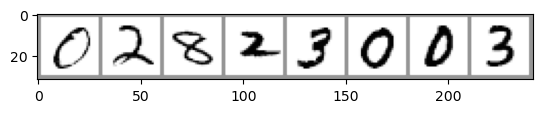

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

training_loader,validation_loader = data_get_load(8)

dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(str(labels[j].numpy()) for j in range(8)))

### Model

In [7]:
import torch.nn as nn
import torch.nn.functional as F

# PyTorch models inherit from torch.nn.Module
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = LeNet()
model.to(device)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [8]:
loss_fn = torch.nn.CrossEntropyLoss()

In [9]:
optimizer = torch.optim.Adam(model.parameters())

### Trainer

In [10]:
# train One epoch

def train_one_epoch(model,train_loader,loss_fn,optimizer,device,epoch_index,tb_writer,wandb=None,write = True):

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    running_loss =0
    last_loss = 0
    losses=[]
    for i,data in enumerate(training_loader):
        inputs,labels = data
        inputs,labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()        
        outputs=model(inputs)
        loss = loss_fn(outputs,labels)
        loss.backward()
        optimizer.step()
        if wandb != None:
            wandb.log({"train_loss": loss.item()})
        running_loss +=loss.item()
        losses.append(loss.item())
        if i%1000 == 990:
            last_loss = running_loss/100
            print(f"{i+1}th batch => {last_loss}")
            if(write):
                tb_x = epoch_index * len(training_loader)
                tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.
    if last_loss==0:
        return np.mean(np.array(losses))
    return last_loss

In [11]:
# test one epoch
def test_one_epoch(model,test_loader,loss_fn,device,wandb=None):

    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()
    running_loss =0
    last_loss = 0
    correct = 0
    with torch.no_grad():
        for i,data in enumerate(test_loader):
            inputs,labels = data
            inputs,labels = inputs.to(device), labels.to(device)

            outputs=model(inputs)
            
            loss = loss_fn(outputs,labels)
            running_loss +=loss.item()
            _,preds = torch.max(outputs,1)
            correct += (preds == labels).sum().item()
            # if wandb!=None:
                
                # Accuracy(preds, labels)
                # # precision(preds, labels)
                # # recall(preds, labels)
                # # f1(preds, labels)
                # # wandb.log({"accuracy": accuracy.compute(), "precision": precision.compute(), "recall": recall.compute(), "f1": f1.compute()})
                # wandb.log({"vloss":loss.item(),"accuracy": ((preds == labels).sum())/len(labels).compute()})
    
                # # Reset metrics
                # Accuracy.reset()
                # # precision.reset()
                # # recall.reset()
                # # f1.reset()
    accuracy = correct/len(test_loader.dataset)
    return running_loss/len(test_loader.dataset) , accuracy    

In [12]:
# # Initializing in a separate cell so we can easily add more epochs to the same run
# timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
# writer = SummaryWriter('runs/mnist_trainer_{}'.format(timestamp))
# epoch_number = 0

# EPOCHS = 2

# best_vloss = 1_000_000.

# for epoch in range(EPOCHS):
    
#     print('EPOCH {}:'.format(epoch_number + 1))
    
#     avg_loss = train_one_epoch(model,training_loader,loss_fn,optimizer,device,epoch_number, writer)
#     avg_vloss,v_acc = test_one_epoch(model,validation_loader,loss_fn,device)
    
#     print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

#     # Log the running loss averaged per batch
#     # for both training and validation
#     writer.add_scalars('Training vs. Validation Loss',
#                     { 'Training' : avg_loss, 'Validation' : avg_vloss },
#                     epoch_number + 1)
#     writer.flush()

#     # Track best performance, and save the model's state
#     if avg_vloss < best_vloss:
#         best_vloss = avg_vloss
#         model_path = './models/model_{}_{}'.format(timestamp, epoch_number)
#         torch.save(model.state_dict(), model_path)

#     epoch_number += 1

In [13]:
saved_model = LeNet()
saved_model.load_state_dict(torch.load("./models/model_20240306_121901_0", map_location=device))
saved_model.to(device)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [14]:
saved_model.eval()

correct =0
# Disable gradient computation and reduce memory consumption.
with torch.no_grad():
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = vdata
        vinputs,vlabels=vinputs.to(device),vlabels.to(device)
        voutputs = saved_model(vinputs)

        _,predicted = torch.max(voutputs,1)
        correct += (predicted == vlabels).sum().item()
accuracy = correct/len(validation_loader.dataset)
print(accuracy)

0.987


### wandb

In [15]:
import wandb
from pprint import pprint

In [16]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sriharib128. Use `wandb login --relogin` to force relogin


True

In [17]:
run = wandb.init(project="CV_A1_Q2",name = "1st run")
wandb.config.learning_rate = 0.001
wandb.config.batch_size = 64
wandb.config.epoch = 10
wandb.config.optimizer = "adam"
pprint(wandb.config)

{'learning_rate': 0.001, 'batch_size': 64, 'epoch': 10, 'optimizer': 'adam'}


In [18]:
model = LeNet()
model.to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=wandb.config.learning_rate)

In [19]:
training_loader,validation_loader = data_get_load(wandb.config.batch_size)

Training set has 60000 instances
Validation set has 10000 instances


In [20]:
len(validation_loader)

157

In [21]:
# from torchmetrics import Accuracy, Precision, Recall, F1Score
# # Initialize metrics
# num_classes = 10
# accuracy = Accuracy(task='multiclass',num_classes=num_classes).to(device)
# precision = Precision(task='multiclass', average='macro', num_classes=num_classes).to(device)
# recall = Recall(task='multiclass', average='macro', num_classes=num_classes).to(device)
# f1 = F1Score(task='multiclass', average='macro', num_classes=num_classes).to(device)

In [22]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
best_vloss = 1_000_000.
# Training loop
for epoch_number in range(wandb.config.epoch):  # Number of epochs
    correct = 0
    total = 0
    print('EPOCH {}:'.format(epoch_number + 1))
    avg_loss = train_one_epoch(model,training_loader,loss_fn,optimizer,device,epoch_number,None,None,write=False)
    avg_vloss,v_acc = test_one_epoch(model,validation_loader,loss_fn,device,None)

    wandb.log({"train_loss":avg_loss,"vloss":avg_vloss,"accuracy":v_acc})
    
    print('LOSS train {} valid {} ACC {}'.format(avg_loss, avg_vloss,v_acc))

    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = './models/model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)
        print(f"saved model to {model_path}")

# exort to ONNX and save in Netron for Vizualization
wandb.save("model.pth")

# Finish the run
run.finish()

EPOCH 1:
100th batch => 1.0806842792034148
200th batch => 0.278742106705904
300th batch => 0.18545835487544537
400th batch => 0.14566997803747653
500th batch => 0.13438145775347948
600th batch => 0.12050811596214771
700th batch => 0.10242413160391152
800th batch => 0.09857013694010675
900th batch => 0.07522635676898062
LOSS train 0.07522635676898062 valid 0.0011488795249490068 ACC 0.9773
saved model to ./models/model_20240307_005452_0
EPOCH 2:
100th batch => 0.07315306286327541
200th batch => 0.0692412838852033
300th batch => 0.07584246435202659
400th batch => 0.06203115314245224
500th batch => 0.05894677390344441
600th batch => 0.06735840604756958
700th batch => 0.06499053363222629
800th batch => 0.05043961589224637
900th batch => 0.05441587164299563
LOSS train 0.05441587164299563 valid 0.0006031600922862708 ACC 0.9875
saved model to ./models/model_20240307_005452_1
EPOCH 3:
100th batch => 0.04953925197711215
200th batch => 0.04277902920497581
300th batch => 0.047060423730872575
400th

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁▆▆▇▇█▅▇██
train_loss,█▅▅▄▄▂▂▂▁▁
vloss,█▂▂▂▂▁▃▂▁▂
accuracy,0.9906
train_loss,0.01834
vloss,0.00058


## Hyperparameter tuning

In [20]:
def build_optimizer(model, optimizer, learning_rate):
    if optimizer == "sgd":
        optimizer = torch.optim.SGD(model.parameters(),
                              lr=learning_rate, momentum=0.9)
    elif optimizer == "adam":
        optimizer = torch.optim.Adam(model.parameters(),
                               lr=learning_rate)
    return optimizer

In [22]:
configs_sweep=[]
accuracies_sweep=[]
def train(config=None):
    # Initialize a new wandb run
    with wandb.init(config=config):
        # If called by wandb.agent, as below,
        # this config will be set by Sweep Controller
        config = wandb.config
        pprint(wandb.config)
        
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        training_loader,validation_loader = data_get_load(wandb.config.batch_size)
        
        model = LeNet()
        model.to(device)
        loss_fn = torch.nn.CrossEntropyLoss()
        optimizer = build_optimizer(model, config.optimizer, config.learning_rate)

        for epoch_number in range(config.epochs):
            avg_loss = train_one_epoch(model,training_loader,loss_fn,optimizer,device,epoch_number,None,None,write=False)
            avg_vloss,v_acc = test_one_epoch(model,validation_loader,loss_fn,device,None)
            print('EPOCH {}  LOSS train {} valid {} ACC {}'.format(epoch_number,avg_loss, avg_vloss,v_acc))
        
            wandb.log({"train_loss":avg_loss,"vloss":avg_vloss,"accuracy":v_acc})
        configs_sweep.append(wandb.config)
        accuracies_sweep.append(v_acc)

In [23]:
# Sweep Configuration
sweep_config = {
    'method': 'random', # Use random search strategy
    'metric': { # The metric that you want to optimize
        'name': 'v_loss',
        'goal': 'minimize'
    },
    'parameters': { # The hyperparameters to tune
        'learning_rate': {  # Learning rate for the optimizer
            'values': [0.001,  0.01,  0.1]
        },
        'optimizer': {  # The optimizer to use
            'values': ['sgd', 'adam']
        },
        # 'dropout': {    # The dropout to use
        #     'values': [0.2,  0.3,  0.5]
        # },
        'batch_size': {    # The batch size
            'values': [8, 32,  64,  128]
        },
        'epochs': {    # The number of epochs
            'values': [1, 2, 5]}
    }
}

In [24]:
# Initialize the sweep
sweep_id = wandb.sweep(sweep_config, project="CV_A1_Q2")

Create sweep with ID: n67d31si
Sweep URL: https://wandb.ai/sriharib128/CV_A1_Q2/sweeps/n67d31si


In [25]:
wandb.agent(sweep_id, function=train, count=6)

wandb: Agent Starting Run: sde5nc2g with config:
wandb: 	batch_size: 8
wandb: 	epochs: 2
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


{'batch_size': 8, 'epochs': 2, 'learning_rate': 0.01, 'optimizer': 'sgd'}
Training set has 60000 instances
Validation set has 10000 instances
991th batch => 6.199817708885821
1991th batch => 1.9512392409095447
2991th batch => 1.4760686647960757
3991th batch => 1.4342516511253416
4991th batch => 1.363316169644786
5991th batch => 1.0689968463997501
6991th batch => 0.9770755575004568
EPOCH 0  LOSS train 0.9770755575004568 valid 0.009310698428575875 ACC 0.9801
991th batch => 0.8658552823110471
1991th batch => 0.9081417675380521
2991th batch => 0.8081263348053176
3991th batch => 0.8740566581206304
4991th batch => 0.8828560253883018
5991th batch => 0.6761636387081168
6991th batch => 0.7688354334256431
EPOCH 1  LOSS train 0.7688354334256431 valid 0.010729170000831527 ACC 0.9772


accuracy,█▁
train_loss,█▁
vloss,▁█
accuracy,0.9772
train_loss,0.76884
vloss,0.01073


wandb: Agent Starting Run: 5d5sx3tb with config:
wandb: 	batch_size: 64
wandb: 	epochs: 2
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


{'batch_size': 64, 'epochs': 2, 'learning_rate': 0.01, 'optimizer': 'adam'}
Training set has 60000 instances
Validation set has 10000 instances
991th batch => 5.9535355256717954
1991th batch => 3.643395198010767
2991th batch => 3.246582798172531
3991th batch => 3.1055301993461852
4991th batch => 2.992721924104635
5991th batch => 3.450461768097903
6991th batch => 2.782694114650494
EPOCH 0  LOSS train 2.782694114650494 valid 0.004004671387956477 ACC 0.9382
991th batch => 2.464102068541033
1991th batch => 2.6414060895377394
2991th batch => 3.8021285598175405
3991th batch => 2.8518025973479326
4991th batch => 2.76539727376934
5991th batch => 2.435629045981859
6991th batch => 2.917860223295287
EPOCH 1  LOSS train 2.917860223295287 valid 0.00445732772985939 ACC 0.9338


accuracy,█▁
train_loss,▁█
vloss,▁█
accuracy,0.9338
train_loss,2.91786
vloss,0.00446


wandb: Agent Starting Run: gskk3bky with config:
wandb: 	batch_size: 8
wandb: 	epochs: 5
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


{'batch_size': 8, 'epochs': 5, 'learning_rate': 0.01, 'optimizer': 'sgd'}
Training set has 60000 instances
Validation set has 10000 instances
991th batch => 5.555144281192334
1991th batch => 1.9606740361348238
2991th batch => 1.6434143149103055
3991th batch => 1.3617520053270709
4991th batch => 1.2111913919699646
5991th batch => 1.0585869540745398
6991th batch => 0.9975825737698892
EPOCH 0  LOSS train 0.9975825737698892 valid 0.011156678332335133 ACC 0.9759
991th batch => 0.8965585691227651
1991th batch => 0.8465718136889282
2991th batch => 0.875246096716833
3991th batch => 1.0381276281927228
4991th batch => 0.8737072891670356
5991th batch => 0.8787772647239762
6991th batch => 0.7612336578960313
EPOCH 1  LOSS train 0.7612336578960313 valid 0.01093846969395756 ACC 0.9752
991th batch => 0.7473053605409187
1991th batch => 0.7602576802508585
2991th batch => 0.7190579896600253
3991th batch => 0.7655185304154587
4991th batch => 0.7775383908089682
5991th batch => 0.8670465260989808
6991th bat

accuracy,▂▁█▇▇
train_loss,█▄▆▁▄
vloss,█▇▄▁▅
accuracy,0.9817
train_loss,0.77372
vloss,0.01033


wandb: Agent Starting Run: md0ua9ae with config:
wandb: 	batch_size: 128
wandb: 	epochs: 2
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


{'batch_size': 128, 'epochs': 2, 'learning_rate': 0.001, 'optimizer': 'sgd'}
Training set has 60000 instances
Validation set has 10000 instances
991th batch => 18.251741362810137
1991th batch => 3.6916667104233056
2991th batch => 2.225923065857496
3991th batch => 1.6432018884108401
4991th batch => 1.3863097810960607
5991th batch => 1.262583292920026
6991th batch => 1.0538932435296011
EPOCH 0  LOSS train 1.0538932435296011 valid 0.0005787050933082355 ACC 0.9766
991th batch => 0.8185956264671403
1991th batch => 0.8079232912659791
2991th batch => 0.7871296330192127
3991th batch => 0.8793787902929762
4991th batch => 0.8212653600725752
5991th batch => 0.7263649462335888
6991th batch => 0.6841008702052204
EPOCH 1  LOSS train 0.6841008702052204 valid 0.0004645774460863322 ACC 0.9808


accuracy,▁█
train_loss,█▁
vloss,█▁
accuracy,0.9808
train_loss,0.6841
vloss,0.00046


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cle36q8b with config:
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	learning_rate: 0.1
wandb: 	optimizer: adam
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


{'batch_size': 32, 'epochs': 5, 'learning_rate': 0.1, 'optimizer': 'adam'}
Training set has 60000 instances
Validation set has 10000 instances
991th batch => 43.176880449056625
1991th batch => 23.25671637058258
2991th batch => 23.26226585149765
3991th batch => 23.29083756685257
4991th batch => 23.300664513111116
5991th batch => 23.28980432987213
6991th batch => 23.253890569210053
EPOCH 0  LOSS train 23.253890569210053 valid 0.07289276967048645 ACC 0.0974
991th batch => 23.04339464187622
1991th batch => 23.26725379943848
2991th batch => 23.270063302516938
3991th batch => 23.266925988197325
4991th batch => 23.293243842124937
5991th batch => 23.286218147277832
6991th batch => 23.263929541110993
EPOCH 1  LOSS train 23.263929541110993 valid 0.0730980437040329 ACC 0.1009
991th batch => 23.04179944753647
1991th batch => 23.270401695966722
2991th batch => 23.290198802947998
3991th batch => 23.2828069460392
4991th batch => 23.284330325126646
5991th batch => 23.26169182538986
6991th batch => 23.

accuracy,▃▆▃█▁
train_loss,▁▂▄▁█
vloss,▃▆█▂▁
accuracy,0.0958
train_loss,23.31808
vloss,0.07274


wandb: Agent Starting Run: 7wvjejpc with config:
wandb: 	batch_size: 8
wandb: 	epochs: 5
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


{'batch_size': 8, 'epochs': 5, 'learning_rate': 0.001, 'optimizer': 'sgd'}
Training set has 60000 instances
Validation set has 10000 instances
991th batch => 19.726857138574122
1991th batch => 3.814682405143976
2991th batch => 2.160127644990571
3991th batch => 1.648054756843485
4991th batch => 1.395670606972999
5991th batch => 1.26193905666325
6991th batch => 1.017983746008831
EPOCH 0  LOSS train 1.017983746008831 valid 0.009516581569721166 ACC 0.9754
991th batch => 0.7380682827746204
1991th batch => 0.8154659192747203
2991th batch => 0.7667398886381125
3991th batch => 0.7661959799614851
4991th batch => 0.6901234278800257
5991th batch => 0.6469269450075807
6991th batch => 0.6675393139977314
EPOCH 1  LOSS train 0.6675393139977314 valid 0.005608304884928657 ACC 0.9837
991th batch => 0.6015153157677924
1991th batch => 0.5060312783921836
2991th batch => 0.4802379263797411
3991th batch => 0.5308238622986391
4991th batch => 0.52842489370978
5991th batch => 0.49618744035564305
6991th batch =>

accuracy,▁▅▇██
train_loss,█▄▂▂▁
vloss,█▃▂▁▁
accuracy,0.989
train_loss,0.3853
vloss,0.00427


In [26]:
for i in range(6):
    print(configs_sweep[i],accuracies_sweep[i])

{'batch_size': 8, 'epochs': 2, 'learning_rate': 0.01, 'optimizer': 'sgd'} 0.9772
{'batch_size': 64, 'epochs': 2, 'learning_rate': 0.01, 'optimizer': 'adam'} 0.9338
{'batch_size': 8, 'epochs': 5, 'learning_rate': 0.01, 'optimizer': 'sgd'} 0.9817
{'batch_size': 128, 'epochs': 2, 'learning_rate': 0.001, 'optimizer': 'sgd'} 0.9808
{'batch_size': 32, 'epochs': 5, 'learning_rate': 0.1, 'optimizer': 'adam'} 0.0958
{'batch_size': 8, 'epochs': 5, 'learning_rate': 0.001, 'optimizer': 'sgd'} 0.989


## Changing Training Size

In [17]:
from sklearn.model_selection import StratifiedShuffleSplit

def data_get_load_num_samp(batch_size=64, num_training_samples=600):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    # Create datasets for training & validation, download if necessary
    training_set = datasets.MNIST('./data', train=True, transform=transform, download=True)
    validation_set = datasets.MNIST('./data', train=False, transform=transform, download=True)

    if num_training_samples == len(training_set):
        subset_train_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True)
    else:
        sss = StratifiedShuffleSplit(n_splits=1, train_size=num_training_samples, random_state=42)
        indices = list(range(len(training_set)))

        for _, subset_indices in sss.split(indices, training_set.targets):
            subset_train_dataset = torch.utils.data.Subset(training_set, subset_indices)

        subset_train_loader = torch.utils.data.DataLoader(subset_train_dataset, batch_size=batch_size, shuffle=True)

    validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=False)

    # Report split sizes
    print('Training set has {} instances'.format(len(training_loader)*batch_size))
    print('Validation set has {} instances'.format(len(validation_set)))

    return subset_train_loader, validation_loader

In [18]:
# Example usage
batch_size = 8
num_training_samples = 600
training_loader, validation_loader = data_get_load_num_samp(batch_size, num_training_samples)

Training set has 60000 instances
Validation set has 10000 instances


In [21]:
training_szs = [600,1800,6000,18000,60000]
accuracies_sz =[]
for num_training_samples in training_szs:
    # {'batch_size': 8, 'epochs': 5, 'learning_rate': 0.001, 'optimizer': 'sgd'} 0.989
    run = wandb.init(project="CV_A1_Q2",name = f"{num_training_samples}_sz_run")
    wandb.config.learning_rate = 0.001
    wandb.config.batch_size = 8
    wandb.config.epoch = 5
    wandb.config.optimizer = "sgd"
    pprint(wandb.config)
    
    model = LeNet()
    model.to(device)
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = build_optimizer(model, wandb.config.optimizer, wandb.config.learning_rate)
    training_loader, validation_loader = data_get_load_num_samp(wandb.config.batch_size, num_training_samples)
    
    # Training loop
    for epoch_number in range(wandb.config.epoch):  # Number of epochs
        correct = 0
        total = 0
        print('EPOCH {}:'.format(epoch_number + 1))
        avg_loss = train_one_epoch(model,training_loader,loss_fn,optimizer,device,epoch_number,None,None,write=False)
        avg_vloss,v_acc = test_one_epoch(model,validation_loader,loss_fn,device,None)
        accuracies_sz.append(v_acc)
        # wandb.log({"train_loss":avg_loss,"vloss":avg_vloss,"accuracy":v_acc})
        
        print('LOSS train {} valid {} ACC {}'.format(avg_loss, avg_vloss,v_acc))
    
        # if avg_vloss < best_vloss:
        #     best_vloss = avg_vloss
        #     model_path = './models/model_{}_{}'.format(timestamp, epoch_number)
        #     torch.save(model.state_dict(), model_path)
        #     print(f"saved model to {model_path}")
    
    # exort to ONNX and save in Netron for Vizualization
    wandb.save(f"model_sz_{num_training_samples}.pth")
    
    # Finish the run
    run.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


{'learning_rate': 0.001, 'batch_size': 8, 'epoch': 5, 'optimizer': 'sgd'}
Training set has 59400 instances
Validation set has 10000 instances
EPOCH 1:
991th batch => 19.716490553468464
1991th batch => 4.283347495645285
2991th batch => 2.266541637857445
3991th batch => 1.6153097458177945
4991th batch => 1.4292962787963917
5991th batch => 1.2433192918397253
6991th batch => 1.1153982854256173
LOSS train 1.1153982854256173 valid 0.01042411605834859 ACC 0.9734
EPOCH 2:
991th batch => 0.8794164806067419
1991th batch => 0.8936300629776087
2991th batch => 0.8577824517313275
3991th batch => 0.8126860227557335
4991th batch => 0.7884754716328461
5991th batch => 0.667460732046893
6991th batch => 0.7423538828032906
LOSS train 0.7423538828032906 valid 0.008188361717084263 ACC 0.9779
EPOCH 3:
991th batch => 0.6124047179418994
1991th batch => 0.5940694429953146
2991th batch => 0.4688924559580119
3991th batch => 0.638485674167332
4991th batch => 0.5231571778328725
5991th batch => 0.5466046649817872
699

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


{'learning_rate': 0.001, 'batch_size': 8, 'epoch': 5, 'optimizer': 'sgd'}
Training set has 59400 instances
Validation set has 10000 instances
EPOCH 1:
991th batch => 17.931882173418998
1991th batch => 3.488474889723584
2991th batch => 2.1237279360496903
3991th batch => 1.7077965395327193
4991th batch => 1.4056668718057335
5991th batch => 1.0725005735235755
6991th batch => 1.1057890340432641
LOSS train 1.1057890340432641 valid 0.009885813512200548 ACC 0.9727
EPOCH 2:
991th batch => 0.8958692277227237
1991th batch => 0.9376205147172731
2991th batch => 0.7822756317045423
3991th batch => 0.7619671013974585
4991th batch => 0.7133534364160005
5991th batch => 0.6701670838576683
6991th batch => 0.6544091241045681
LOSS train 0.6544091241045681 valid 0.008771998516387793 ACC 0.977
EPOCH 3:
991th batch => 0.6274574348742317
1991th batch => 0.534560358030185
2991th batch => 0.49623516275019935
3991th batch => 0.6069044608745026
4991th batch => 0.5250114362096064
5991th batch => 0.597587725399535
6

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


{'learning_rate': 0.001, 'batch_size': 8, 'epoch': 5, 'optimizer': 'sgd'}
Training set has 58200 instances
Validation set has 10000 instances
EPOCH 1:
991th batch => 18.77893069319427
1991th batch => 3.5870828445395455
2991th batch => 1.9477365525811912
3991th batch => 1.5271843220689334
4991th batch => 1.2028006419719894
5991th batch => 1.0486058651804342
LOSS train 1.0486058651804342 valid 0.010765049795598315 ACC 0.974
EPOCH 2:
991th batch => 0.8049659157040878
1991th batch => 0.7744179477349826
2991th batch => 0.721701927616814
3991th batch => 0.7174861475732905
4991th batch => 0.736957708865666
5991th batch => 0.6663634901182377
LOSS train 0.6663634901182377 valid 0.007648019589772411 ACC 0.9792
EPOCH 3:
991th batch => 0.52258401780844
1991th batch => 0.5004806537099649
2991th batch => 0.5026932452525944
3991th batch => 0.5971520794451499
4991th batch => 0.5540874966838237
5991th batch => 0.4545160540309553
LOSS train 0.4545160540309553 valid 0.006731712759686025 ACC 0.9826
EPOCH 

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


{'learning_rate': 0.001, 'batch_size': 8, 'epoch': 5, 'optimizer': 'sgd'}
Training set has 54000 instances
Validation set has 10000 instances
EPOCH 1:
991th batch => 18.064601043313743
1991th batch => 4.036260690200143
2991th batch => 2.1042611017404123
3991th batch => 1.5491846019320656
4991th batch => 1.3320207431871678
LOSS train 1.3320207431871678 valid 0.01119130895459166 ACC 0.9718
EPOCH 2:
991th batch => 0.9970751686237054
1991th batch => 1.018966915748897
2991th batch => 0.9639669638319174
3991th batch => 0.8161329163158371
4991th batch => 0.7015853467107082
LOSS train 0.7015853467107082 valid 0.007951130247549737 ACC 0.9806
EPOCH 3:
991th batch => 0.6112134303327912
1991th batch => 0.6799282913257048
2991th batch => 0.6763220237097994
3991th batch => 0.5794903275343313
4991th batch => 0.5782596125367491
LOSS train 0.5782596125367491 valid 0.0071260883230621404 ACC 0.9819
EPOCH 4:
991th batch => 0.4808832222081946
1991th batch => 0.45750581416385105
2991th batch => 0.5315824604

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


{'learning_rate': 0.001, 'batch_size': 8, 'epoch': 5, 'optimizer': 'sgd'}
Training set has 42000 instances
Validation set has 10000 instances
EPOCH 1:
991th batch => 21.61618161678314
1991th batch => 4.918200996457599
2991th batch => 2.027779280936811
3991th batch => 1.5133260567381512
4991th batch => 1.3129504362941953
5991th batch => 1.1606016338180052
6991th batch => 0.9585320368545944
LOSS train 0.9585320368545944 valid 0.008910342039550597 ACC 0.9769
EPOCH 2:
991th batch => 0.8490426356942044
1991th batch => 0.8951822807853751
2991th batch => 0.785539933492837
3991th batch => 0.7297704057794181
4991th batch => 0.6696263434620778
5991th batch => 0.6935060774383601
6991th batch => 0.687125275011349
LOSS train 0.687125275011349 valid 0.0062690844333683346 ACC 0.984
EPOCH 3:
991th batch => 0.5875784376903175
1991th batch => 0.5283521004384238
2991th batch => 0.5324774059837364
3991th batch => 0.5468409317837722
4991th batch => 0.5176831428250444
5991th batch => 0.4901857120474233
6991

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


In [22]:
print(accuracies_sz)
with open("accuracies_sz.pkl","wb") as f:
    pickle.dump(accuracies_sz,f)

[0.9734, 0.9779, 0.9857, 0.9868, 0.9878, 0.9727, 0.977, 0.9833, 0.9873, 0.9861, 0.974, 0.9792, 0.9826, 0.9865, 0.9865, 0.9718, 0.9806, 0.9819, 0.9834, 0.9866, 0.9769, 0.984, 0.9814, 0.9881, 0.9893]


In [25]:
accuracies_sz[5:5:]

[0.9734, 0.9779, 0.9857, 0.9868, 0.9878]